In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Data, Data Cleaning & Preprocessing

In [4]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Teknologi-Informasi/Praktikum-BigData/nvda.us.txt')

In [5]:
# 1. DATA CLEANING
print("--- 1. Data Cleaning ---")

df = df.drop(columns=['OpenInt'])

# Ubah kolom Date menjadi tipe datetime dan urutkan
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')
print(f"DataFrame awal: {df.shape[0]} baris.")

# Siapkan dataframe khusus untuk membuat feature
data = df[['Close']].copy()

--- 1. Data Cleaning ---
DataFrame awal: 4733 baris.


In [13]:
# 2. DATA PREPROCESSING
print("\n--- 2. Data Preprocessing ---")

# 1. Close_Lag_1 → Harga penutupan 1 hari sebelumnya (fitur paling dasar untuk prediksi)
data['Close_Lag_1'] = data['Close'].shift(1)
# 2. Close_Lag_3 → Harga penutupan 3 hari sebelumnya (melihat pola jangka pendek)
data['Close_Lag_3'] = data['Close'].shift(3)
# 3. MA_5_Lag1 → Rata-rata harga 5 hari terakhir, diambil dari hari sebelumnya (tren mingguan)
data['MA_5_Lag1'] = data['Close'].rolling(window=5).mean().shift(1)
# 4. MA_10_Lag1 → Rata-rata harga 10 hari terakhir, diambil dari hari sebelumnya (tren 2 mingguan)
data['MA_10_Lag1'] = data['Close'].rolling(window=10).mean().shift(1)
# 5. MA_20_Lag1 → Rata-rata harga 20 hari terakhir, diambil dari hari sebelumnya (tren bulanan)
data['MA_20_Lag1'] = data['Close'].rolling(window=20).mean().shift(1)

# Hapus baris NaN (yang disebabkan oleh MA_20 dan lagged features)
data.dropna(inplace=True)

# Menggabungkan dataset dengan fitur tambahan (Menggunakan inner join untuk membuang baris NaN di 'data')
# Hapus kolom 'Close' duplikat yang dibuat Pandas secara otomatis
data_gabungan = df.join(data, how='inner', rsuffix='_fitur')

# Hapus kolom 'Close_fitur' karena duplikat dengan 'Close' yang merupakan target
if 'Close_fitur' in data_gabungan.columns:
    data_gabungan = data_gabungan.drop(columns=['Close_fitur'])

# Pastikan df yang digunakan untuk modeling sudah bersih dan lengkap
df_model = data_gabungan.dropna()
print(f"DataFrame siap modeling (setelah dropna): {df_model.shape[0]} baris.")

# --- SPLIT DATA (SEKUENSIAL - WAJIB UNTUK TIME SERIES) ---
# Tentukan rasio split (70% Train, 30% Test)
TEST_SIZE_RATIO = 0.3
split_point = int(len(df_model) * (1 - TEST_SIZE_RATIO))

# Definisikan Fitur dan Target
X = df_model.drop(columns=['Close'])
Y = df_model['Close']

# Pembagian Sekuensial (Split by Time)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

print(f"\nDATA SPLITTING ({int((1 - TEST_SIZE_RATIO) * 100)}% Train, {int(TEST_SIZE_RATIO * 100)}% Test)")
print(f"Jumlah Total Data Latih (Train): {len(X_train):,}")
print(f"Jumlah Total Data Uji (Test): {len(X_test):,}")


--- 2. Data Preprocessing ---
DataFrame siap modeling (setelah dropna): 4653 baris.

DATA SPLITTING (70% Train, 30% Test)
Jumlah Total Data Latih (Train): 3,257
Jumlah Total Data Uji (Test): 1,396


# Modeling

In [14]:
# 3. MODELING & EVALUATION
print("\n--- 3. Modeling & Evaluation ---")

# MODELING (DIPERBAIKI: Hapus parameter n_estimators)
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Prediksi
lr_pred = lr_model.predict(X_test)

# EVALUASI (DIPERBAIKI: Menggunakan variabel yang benar)
mae = mean_absolute_error(Y_test, lr_pred)
rmse = np.sqrt(mean_squared_error(Y_test, lr_pred))

print(f"=== Evaluasi Model Linear Regression ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- 3. Modeling & Evaluation ---
=== Evaluasi Model Linear Regression ===
Mean Absolute Error (MAE): 0.2490
Root Mean Squared Error (RMSE): 0.4790


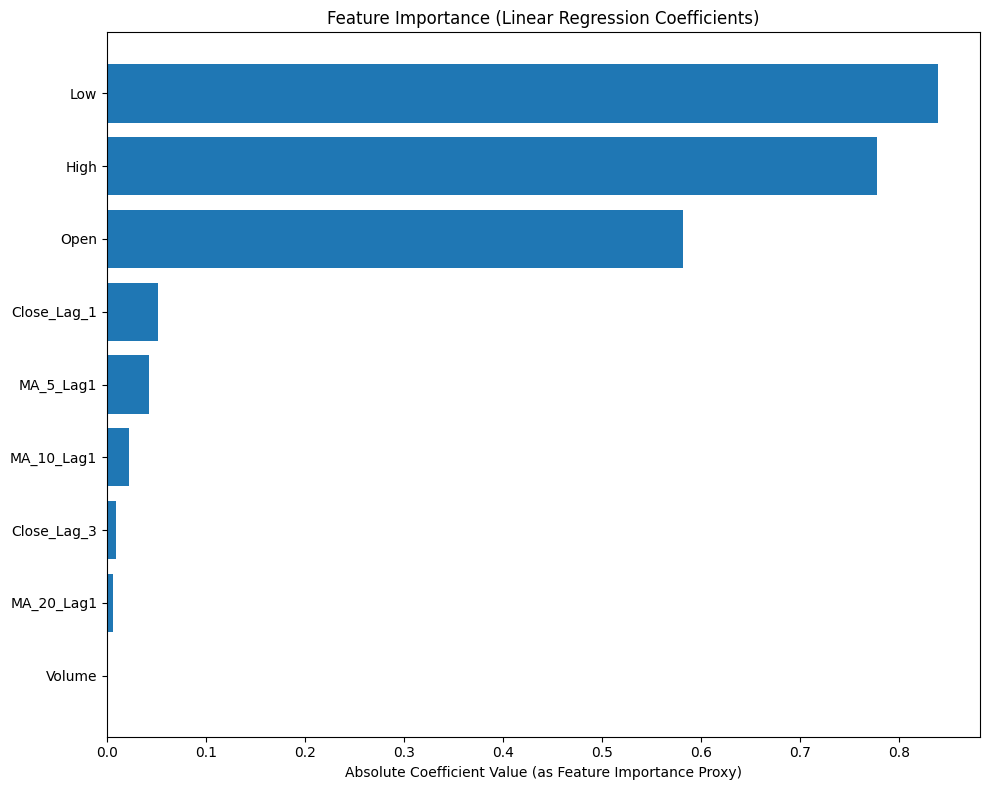

In [8]:
# Melihat Feature berpengaruh
importances = np.abs(lr_model.coef_)

feature_names = X_train.columns

indices = np.argsort(importances)

importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(X_train.shape[1]), importances_sorted, align="center")
plt.yticks(range(X_train.shape[1]), feature_names_sorted)
plt.xlabel("Absolute Coefficient Value (as Feature Importance Proxy)")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.tight_layout()
plt.savefig("feature_importances_lr.png")

In [17]:
# Modeling Ulang Linear Regression

# 1. Seleksi Fitur Penting
features_penting = ['Low', 'High', 'Open', 'Close_Lag_1', 'MA_5_Lag1'] # Menggunakan 5 fitur teratas

X = df_model[features_penting]
Y = df_model['Close']

# Pembagian Sekuensial (Split by Time)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

# --- MODELING BARU ---
print("\n--- Modeling & Evaluation Baru ---")

# Modeling (Linear Regression)
lr_model_baru = LinearRegression()
lr_model_baru.fit(X_train, Y_train)

# Prediksi
lr_pred_baru = lr_model_baru.predict(X_test)

# --- EVALUASI ---
mae_baru = mean_absolute_error(Y_test, lr_pred_baru)
rmse_baru = np.sqrt(mean_squared_error(Y_test, lr_pred_baru))

print(f"\n=== Evaluasi Model (Hanya 5 Fitur Penting) ===")
print(f"Mean Absolute Error (MAE): ${mae_baru:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_baru:.4f}")

--- Data Splitting (dengan Feature Selection) ---
Fitur yang digunakan: ['Low', 'High', 'Open', 'Close_Lag_1', 'MA_5_Lag1']
Jumlah Total Data Latih (Train): 3,257
Jumlah Total Data Uji (Test): 1,396

--- Modeling & Evaluation Baru ---

=== Evaluasi Model (Hanya 5 Fitur Penting) ===
Mean Absolute Error (MAE): $0.2484
Root Mean Squared Error (RMSE): $0.4786


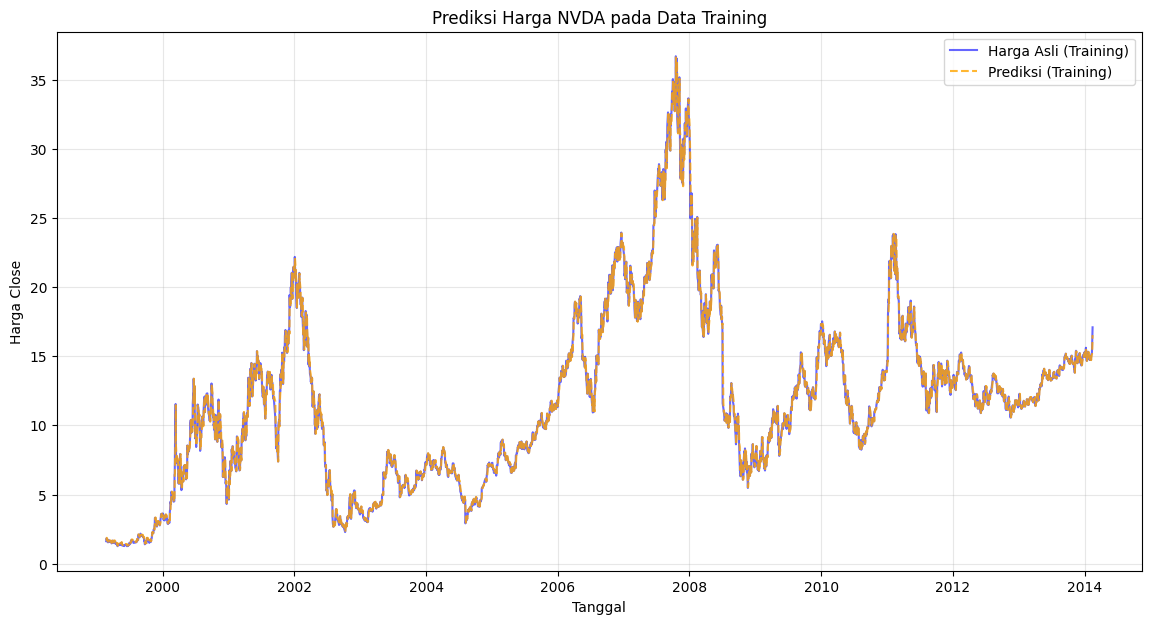

In [ ]:
# # VISUALISASI TRAINING DATA
# plt.figure(figsize=(14, 7))

# # Plot harga asli training
# plt.plot(train_data.index, y_train, label='Harga Asli (Training)', color='blue', alpha=0.6)

# # Plot prediksi training
# plt.plot(train_data.index, train_pred, label='Prediksi (Training)', color='orange', linestyle='--', alpha=0.8)

# plt.title('Prediksi Harga NVDA pada Data Training')
# plt.xlabel('Tanggal')
# plt.ylabel('Harga Close')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()


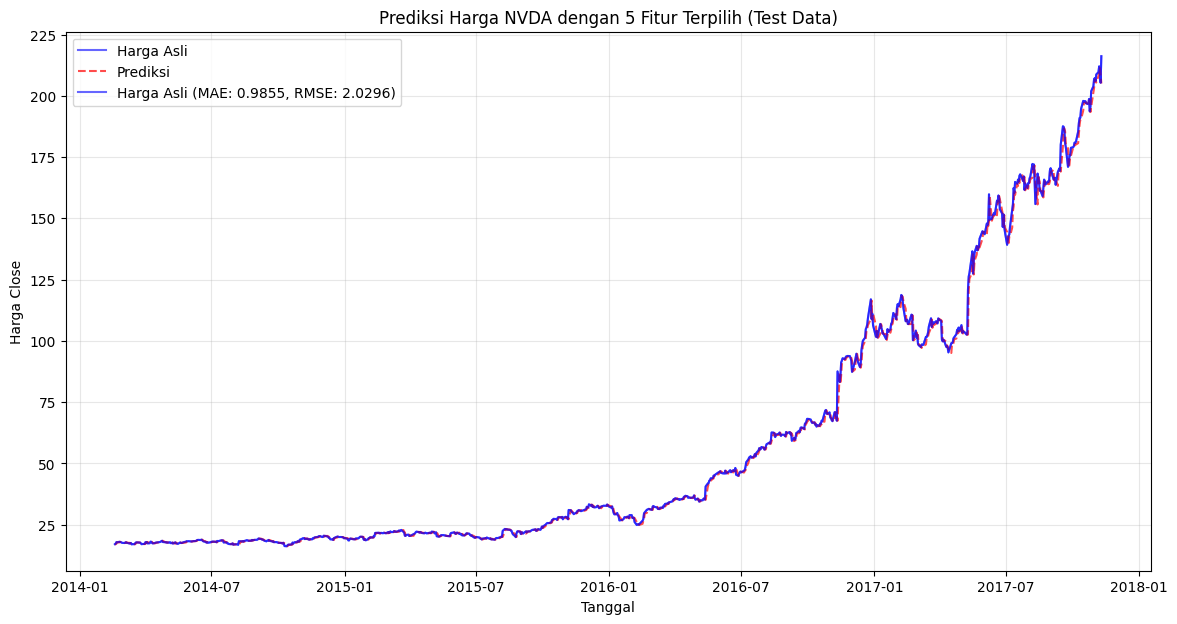

In [ ]:
# # VISUALISASI TEST DATA
# plt.figure(figsize=(14, 7))

# # Plot Data Asli
# plt.plot(test_data.index, y_test, label='Harga Asli', color='blue', alpha=0.6)

# # Plot Prediksi
# plt.plot(test_data.index, test_pred, label='Prediksi', color='red', linestyle='--', alpha=0.7)


# plt.title(f'Prediksi Harga NVDA dengan 5 Fitur Terpilih (Test Data)')
# plt.xlabel('Tanggal')
# plt.ylabel('Harga Close')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def recursive_forecast(model, history, steps=5):
#     predictions = []
#     current_history = history.copy()

#     for i in range(steps):
#         # Hanya gunakan data yang tersedia sampai current point
#         close_series = current_history['Close']

#         # Feature engineering TANPA data leakage
#         features = np.array([
#             close_series.iloc[-1],                    # Close_Lag_1 (hari sebelumnya)
#             close_series.iloc[-10:].mean() if len(close_series) >= 11 else close_series.iloc[:-1].mean(),  # MA_10_Lag1
#             close_series.iloc[-5:].mean() if len(close_series) >= 6 else close_series.iloc[:-1].mean(),    # MA_5_Lag1
#             close_series.iloc[-3] if len(close_series) >= 4 else close_series.iloc[-1],                    # Close_Lag_3
#             close_series.iloc[-20:].mean() if len(close_series) >= 21 else close_series.iloc[:-1].mean()   # MA_20_Lag1
#         ]).reshape(1, -1)

#         pred = model.predict(features)[0]
#         predictions.append(pred)

#         # Tambahkan prediksi ke history untuk recursive forecast
#         next_date = current_history.index[-1] + pd.Timedelta(days=1)
#         # Handle weekend - cari next business day
#         while next_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
#             next_date += pd.Timedelta(days=1)

#         new_row = pd.DataFrame({'Close': [pred]}, index=[next_date])
#         current_history = pd.concat([current_history, new_row])

#     future_dates = current_history.index[-steps:]
#     return np.array(predictions), future_dates


In [ ]:
# # Forecast 5 hari
# horizon_days = 5
# history_for_forecast = data.copy()
# future_preds, future_dates = recursive_forecast(model, history_for_forecast, steps=horizon_days)

# forecast_df = pd.DataFrame({'Predicted_Close': future_preds}, index=future_dates)

# # Cetak prediksi harian
# for date, price in zip(future_dates, future_preds):
#     print(f"{date.date()}: Prediksi Close = ${price:.2f}")

2017-11-13: Prediksi Close = $215.54
2017-11-14: Prediksi Close = $214.66
2017-11-15: Prediksi Close = $214.40
2017-11-16: Prediksi Close = $214.04
2017-11-17: Prediksi Close = $213.48


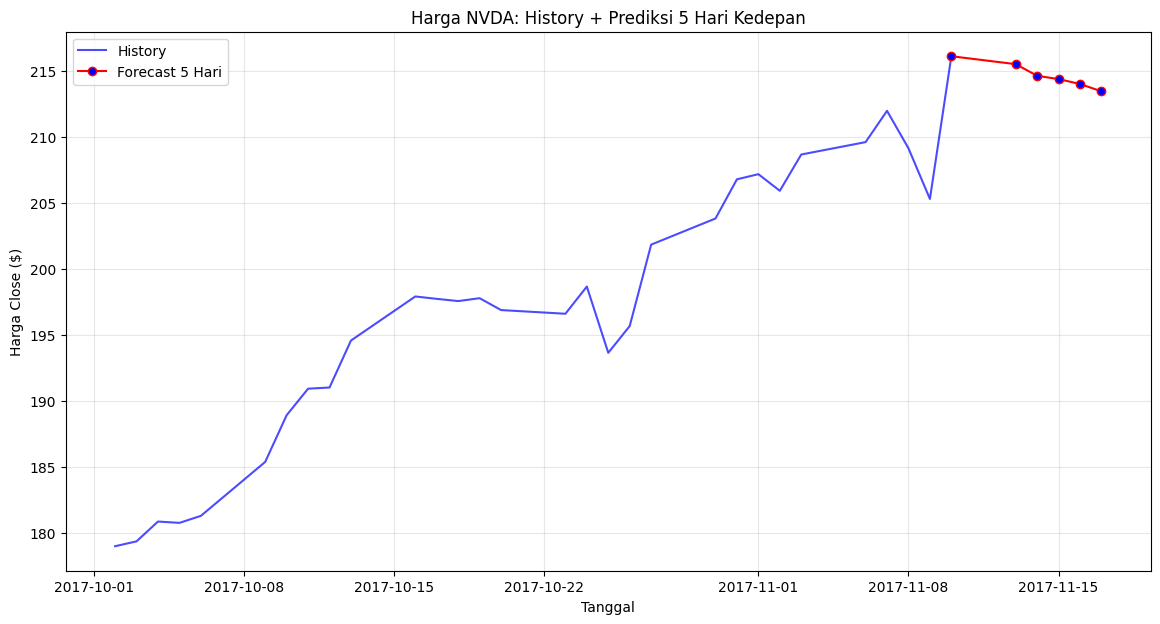

In [ ]:
# # Visualisasi nyambung dengan harga asli
# start_date = '2017-10-01'
# history_to_plot = df[df.index >= start_date]

# plt.figure(figsize=(14, 7))
# plt.plot(history_to_plot.index, history_to_plot['Close'], label='History', color='blue', alpha=0.7)

# last_history_price = history_to_plot['Close'].iloc[-1]
# pred_values_with_last = np.concatenate([[last_history_price], future_preds])
# pred_dates_with_last = pd.Index([history_to_plot.index[-1]]).append(future_dates)

# plt.plot(pred_dates_with_last, pred_values_with_last,
#          label='Forecast 5 Hari',
#          color='red',               # warna garis
#          linestyle='-',
#          marker='o',
#          markerfacecolor='blue',    # isi lingkaran
#          markeredgecolor='red')     # tepi lingkaran sama seperti garis

# plt.title('Harga NVDA: History + Prediksi 5 Hari Kedepan')
# plt.xlabel('Tanggal')
# plt.ylabel('Harga Close ($)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()
